# Extreme Value Distribution

## The question

I encountered an interesting stastistics question on a competition recently and solved it using a numerical approach. Paraphrasing, the question was as follows:

A math wiz asks you to pick a random number using the following approach:

1. Using a standard normal distribution (mean 0, standard deviation 1), generate 1 million random samples
2. Take the largest number you found and round it to the nearest integer
3. Write this number down and keep it hidden

The math wiz thinks he can guess what number you wrote down. If he's wrong, he'll pay you \$150, but if he's right, you owe him \$10. 

The question is thus:

1. What number would the math wiz be guessing and why?
2. Understanding this, is the bet fair or not fair?

---------------------------------------

## A numerical solution

I approached this problem directly by attempting to simulate the result of the experiment enough times to understand the math wiz's thinking. 

Unfortunately, this problem can be computationally intensive since we want to:

1. Generate 10^6 random samples from a normal distribution N(0,1)
2. Identify the maximum value in this list
3. Repeat this X times until we can confidently describe the unknown distribution 

Through some trial and error, I decided that the optimal approach (in Python) was to evaluate the 10^6 samples in serial and distribute the X experiments in parallel.

Let's begin!

(I also did a check of this solution using Igor Pro. See end of this notebook for the code)

## Module dependencies

In [1]:
from scipy.stats import genextreme
import numpy as np
from pylab import plot,show,hist,figure,title,xlim,ylim
from multiprocessing import Pool, cpu_count
%matplotlib inline

### Function setup



In [2]:
CPUS = cpu_count() ## Number of CPUs 
SAMPLES = 10**4    ## I highly recommend reducing this number to 10**2 or 10**3 to start.
DISTSIZE = 10**6   ## Number of samples specified by the math wiz in his challenge

def maxOfDist(_):
    '''Returns the largest random sample from N(0,1) from 10^6 samples'''
    return np.random.randn(DISTSIZE).max()

def randomizeSeed(n):
    '''
    A function that tells the current core to generate a random seed
    Will call this on all cores to randomize them
    '''
    np.random.seed()
    return str(n)
    
## Setup the parallel workflow and randomize the cores
if __name__ == '__main__':
    p = Pool(CPUS)
    out=p.map(randomizeSeed,range(1,CPUS+1))
    print("Cores "+", ".join(out) + " successfully randomized.")

Cores 1, 2, 3, 4, 5, 6, 7, 8 successfully randomized.


### Perform the experiments

This is the expensive calculation (*be patient as it runs, it took 1.5 minutes on my 8 core machine with SAMPLES=10000*). The result is an array of maximal values (we don't store the underlying distributions to save memory). The evaluation is split up evenly across all cores to minimize overhead. 

In [3]:
maxValuesDist = np.array(p.map(maxOfDist,[_]*SAMPLES,chunksize=SAMPLES//CPUS))

### Analyze the results

If you plot a histogram of the data, you find a skewed distribution centered around 4.75 and having a tail on the high side. We'll come back to understanding what this distribution is shortly.

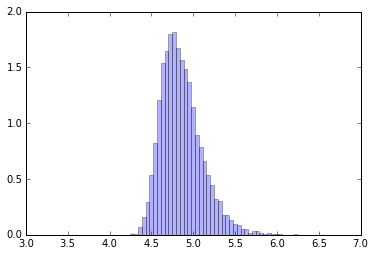

In [4]:
hist(maxValuesDist,50,normed=1,alpha=.3)
xlim(3,7)
show()

Because we are interested in rounding the maximal values to the nearest integer, a better representation of possible outputs would be given as follows.

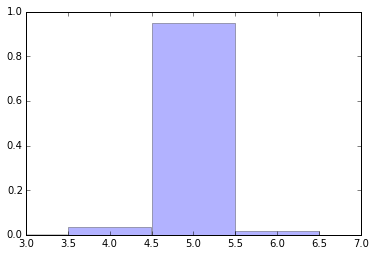

In [5]:
coarseHist=hist(maxValuesDist,bins=[2.5,3.5,4.5,5.5,6.5,7.5],normed=1,alpha=.3)
xlim(3,7)
show()

From this, we can see that there are only 3 likely choices and that 5 is by far the favourite. **Not so random after all!**

Curious about this distribution, I found that it most resembles [an extreme value distribution](https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution). 

We can fit our data to such a distribution using genextreme from scipy.stats (Docs are [here](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html)). Let's check if this works. 

#### Do the fit and check parameters

In [6]:
np.seterr(divide='ignore', invalid='ignore') # ignore errors

param = genextreme.fit(maxValuesDist) # fit to a generalized extreme value distribution

param #[0]: shape parameter, [1]: location parameter, [2]: scale parameter

(0.042513064850128242, 4.7502410896211469, 0.20266453506625759)

#### Plot the fit results

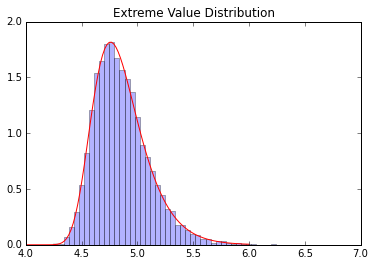

In [7]:
x = np.linspace(4,6,100)

pdf_fitted = genextreme.pdf(x,c=param[0],loc=param[1],scale=param[2])

title('Extreme Value Distribution')
plot(x,pdf_fitted,'r-')
hist(maxValuesDist,50,normed=1,alpha=.3)
show()

As can be seen, the fitted distribution function matches the underlying very well.  

* * *

# Answering the question

We can now see that the numbers that the math wiz would be guessing are well described by an extreme value distribution. The distribution is peaked around 4.75 and nearly all the weight lies in the 4.5 to 5.5 range. Let's find out how much exactly. 

We could bin our results or use the distribution function to evaluate the probability. They should give the same result, so we will compare.

In [8]:
probInRangeCDF=(genextreme.cdf(5.5,c=param[0],loc=param[1],scale=param[2])
                -genextreme.cdf(4.5,c=param[0],loc=param[1],scale=param[2]))

probInRangeHist=max(coarseHist[0])

In [9]:
print(("The likelihood of getting the number 5 is \n"+"-"*42+"\n" + 
      "Distribution function:\t{:0.2%} \nHistogram binning:\t{:0.2%}")
      .format(probInRangeCDF,probInRangeHist))

The likelihood of getting the number 5 is 
------------------------------------------
Distribution function:	94.66% 
Histogram binning:	94.68%


These are in good agreement, as expected.

* * *

**Clearly, the math wiz would be guessing that the number you wrote down is 5 and they would be right about 95% of the time!**

Roughly speaking, if you played the game 20 times, you would lose 19 times and win only once. The odds are 19/1. The bet is **not fair** and you shouldn't take it since his offer of \$150 is less than the break-even point of \$190.

---------------------------------------


## Final thoughts

Although initially I thought this problem would be simple, it taught me two important lessons.

1. Parallelization can be tricky with random numbers in Python and one must be careful that each core is operating with a different random seed.
2. I had not heard about extreme value distributions before. It seems that predicting the distribution of unlikely events is an important topic and poses many challenges in the real world (eg. predicting large earthquakes, component failure, etc.). Intuitively, I feel this problem can be solved analytically, yet I do not know how to do so, not having much of a stats background. If anyone has any ideas, I'd be happy to hear them.


---------------------------------------



### For the Igor Pro people out there (I know there must be a few!)

This problem can be solved in just a few lines of Igor Pro code:

    function evd()
        variable i, n=1000
        make /O /N=(n) nw
        make /O /N=1000000 g
        for(i=0;i<n;i+=1)
            Wave g = root:g; Multithread g = gnoise(1)
            nw[i] = wavemax(g)
        endfor
        Histogram/P/C/B={3.5,1,4} nw,root:nw_Hist
    end


This code finds that 5 occurs with 94.58% probability.  

Curiously, Igor Pro is reasonably efficient at populating a large wave (list) with multithreading even if each evaluation requires a random sample from a gaussian distribution, so I parallelized this step rather than the experiment-level (for loop) steps. 

I could not find an efficient way to replicate the `Multithread g = gnoise(1)` line in Python.

In terms of benchmarking, the overall evaluation time for 10000 experiments was roughly 1:25 in Python and 2:45 in Igor Pro. (8-core Mac Pro Early 2008, 12 GB of RAM). This is overkill, and using SAMPLES=1000 is more than adequate to get a reasonable solution in 1/10th of the time.  